In [1]:
# First approach to Smart Charging Phase 1 using PuLP.
# Modeled as a PuLP optimisation blending problem
# Started 20 Aug 2020
# Author: Sofia Taylor, Flexible Power Systems
# test new laptop

import numpy as np
import pandas as pd
import datetime as dt
from pulp import *
import pickle
import global_variables as gv
import functions as f
import output_functions as of
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import random
import matplotlib.dates as mdates
import matplotlib.font_manager as font_manager
import lin_prog_functions as lpf


In [45]:
run = 68
charger = 22
capacity = 80
ca='opt'
site_capacity = {
    'opt': capacity,  
    'BAU': 10000,
    'BAU2': capacity
}
#grid_file_path = 'Outputs/Logs/grid_variables{}.csv'.format(run)
journeys = pickle.load(open('Outputs/journeys_range','rb'))
eprice = pickle.load(open('Outputs/price_data','rb'))
empty_profile = pickle.load(open('Outputs/empty_profile','rb'))

day = dt.datetime(2019,3,4)
day_profile = f.create_daily_schedule(empty_profile, day)
day_profile.head(10)

Electricity_Price  Time_Price       date  \
from                Vehicle_ID                                             
2019-03-04 11:00:00 3                         8.4        1558 2019-03-04   
                    4                         8.4        1558 2019-03-04   
                    6                         8.4        1558 2019-03-04   
                    11                        8.4        1558 2019-03-04   
                    12                        8.4        1558 2019-03-04   
2019-03-04 11:30:00 3                         8.4        1559 2019-03-04   
                    4                         8.4        1559 2019-03-04   
                    6                         8.4        1559 2019-03-04   
                    11                        8.4        1559 2019-03-04   
                    12                        8.4        1559 2019-03-04   

                                Available  Battery_Use  
from                Vehicle_ID                          
2019-03-04 11:00:00 3                   0      0.00000  
                    4                   0      0.00000  
                    6                   0      0.00000  
                    11                  0      0.00000  
                    12                  0    -22.18828  
2019-03-04 11:30:00 3                   0      0.00000  
                    4                   0      0.00000  
                    6                   0      0.00000  
                    11                  0      0.00000  
                    12                  0      0.00000

In [61]:
# Inlcudes SOC constraints
def linear_optimiser_V3(profile,ca,charger,capacity):
    profile_av = profile[profile['Available'] == 1]
    price_col = gv.CAT_COLS['PRICE'][ca]
    output_col = gv.CAT_COLS['OUTPUT'][ca]
    soc_col = gv.CAT_COLS['SOC'][ca]
    vehicles = profile.index.get_level_values(1).unique()
    time_periods = profile_av.index.get_level_values(0).unique()
    # Define output variable
    outputs = LpVariable.dicts(
        "output",
        ((period, vehicle) for period, vehicle in profile_av.index),
        lowBound = 0,
        upBound = charger * gv.TIME_FRACT,
        cat = "Continuous"
        )

    # Create the 'prob' variable to contain the problem data
    prob = LpProblem("Multiple_route_scheduling",LpMinimize)

    # Add costs to objective function

    prob += lpSum(
        [profile_av.loc[(period, vehicle), price_col] * outputs[period, vehicle] 
        for period, vehicle in profile_av.index]
        ), "Total Charging costs"

    # Final SOC constraint
    for vehicle in vehicles:
        vehicle_prof = profile_av.loc[(slice(None),vehicle),'Battery_Use']
        prob += lpSum(
            [outputs[period,vehicle] * gv.CHARGER_EFF for period, vehicle in vehicle_prof.index]
        ) == - profile.loc[(slice(None),vehicle),'Battery_Use'].sum()

    # Intermediate SOC constraints
    for vehicle in vehicles:
        vehicle_prof = profile_av.loc[(slice(None),vehicle),'Battery_Use']
        for period in vehicle_prof.index.get_level_values(0):
            cumul_use = profile.loc[(slice(period),vehicle),'Battery_Use'].sum()
            cumul_profile = profile_av.loc[(slice(period),vehicle),'Battery_Use']
            prob += lpSum(
                [outputs[period, vehicle] * gv.CHARGER_EFF for period, vehicle in cumul_profile.index]
            ) + cumul_use <= 0
            prob += lpSum(
                [outputs[period, vehicle] * gv.CHARGER_EFF for period, vehicle in cumul_profile.index]
            ) + cumul_use >= -gv.BATTERY_CAPACITY + charger * gv.TIME_FRACT

    # # Max capacity constraint
    # n = len(time_periods.unique())
    # for period in time_periods:
    #     time_routes = list(profile_av.loc[period].index)
    #     prob += lpSum(
    #         [outputs[period, route] for route in time_routes]) <= capacity[ca]* gv.TIME_FRACT

    # # Solve and print to the screen
    # prob.solve()
    # print(ca, "status:", LpStatus[prob.status])
    # # Get output variables
    # charge_output = []
    # for period, route in outputs:
    #     if prob.status == 1:
    #         x =  outputs[(period, route)].varValue
    #     else:
    #         x = 0
    #     var_output = {
    #         'from': period,
    #         'Vehicle_ID': route,
    #         output_col: x
    #     }
    #     charge_output.append(var_output)

    df = pd.DataFrame.from_records(charge_output).sort_values(['from','Vehicle_ID'])
    df.set_index(['from', 'Vehicle_ID'], inplace=True)
    print('Cost:', value(prob.objective))
    return df, prob

In [62]:
output_df, PuLP_prob = linear_optimiser_V3(
                    day_profile,
                    ca,
                    charger,
                    site_capacity
                    )

day_profile_out = day_profile.merge(
                output_df,
                how='left',
                left_index=True,
                right_index=True,
                )
range_profile = day_profile_out.fillna(0)
cols=gv.CAT_COLS
vehicles = output_df.index.get_level_values(1).unique()

range_profile[cols['CHARGE_DEL'][ca]] = (
    range_profile[cols['OUTPUT'][ca]] 
    * gv.CHARGER_EFF)
range_profile[cols['ECOST'][ca]] = (
    range_profile[cols['OUTPUT'][ca]] 
    * range_profile[cols['PRICE']['opt']])
for vehicle in vehicles:
    range_profile.loc[(slice(None),vehicle),cols['SOC'][ca]] = (
        gv.BATTERY_CAPACITY
        + range_profile.loc[(slice(None),vehicle),cols['CHARGE_DEL'][ca]].cumsum() 
        + range_profile.loc[(slice(None),vehicle),'Battery_Use'].cumsum()
        )*100/gv.BATTERY_CAPACITY

opt status: Optimal
Cost: 2215.0006519199997


In [63]:
range_profile

Electricity_Price  Time_Price       date  \
from                Vehicle_ID                                             
2019-03-04 11:00:00 3                        8.40        1558 2019-03-04   
                    4                        8.40        1558 2019-03-04   
                    6                        8.40        1558 2019-03-04   
                    11                       8.40        1558 2019-03-04   
                    12                       8.40        1558 2019-03-04   
...                                           ...         ...        ...   
2019-03-05 10:30:00 3                        8.28        1605 2019-03-04   
                    4                        8.28        1605 2019-03-04   
                    6                        8.28        1605 2019-03-04   
                    11                       8.28        1605 2019-03-04   
                    12                       8.28        1605 2019-03-04   

                                Available  Battery_Use  Output_Opt  \
from                Vehicle_ID                                       
2019-03-04 11:00:00 3                   0      0.00000         0.0   
                    4                   0      0.00000         0.0   
                    6                   0      0.00000         0.0   
                    11                  0      0.00000         0.0   
                    12                  0    -22.18828         0.0   
...                                   ...          ...         ...   
2019-03-05 10:30:00 3                   0      0.00000         0.0   
                    4                   0      0.00000         0.0   
                    6                   0      0.00000         0.0   
                    11                  0      0.00000         0.0   
                    12                  0      0.00000         0.0   

                                ChDelivered_Opt  ECost_Opt     SoC_Opt  
from                Vehicle_ID                                          
2019-03-04 11:00:00 3                       0.0        0.0  100.000000  
                    4                       0.0        0.0  100.000000  
                    6                       0.0        0.0  100.000000  
                    11                      0.0        0.0  100.000000  
                    12                      0.0        0.0   70.415627  
...                                         ...        ...         ...  
2019-03-05 10:30:00 3                       0.0        0.0  100.000000  
                    4                       0.0        0.0  100.000000  
                    6                       0.0        0.0  100.000000  
                    11                      0.0        0.0  100.000000  
                    12                      0.0        0.0  100.000000  

[240 rows x 9 columns]

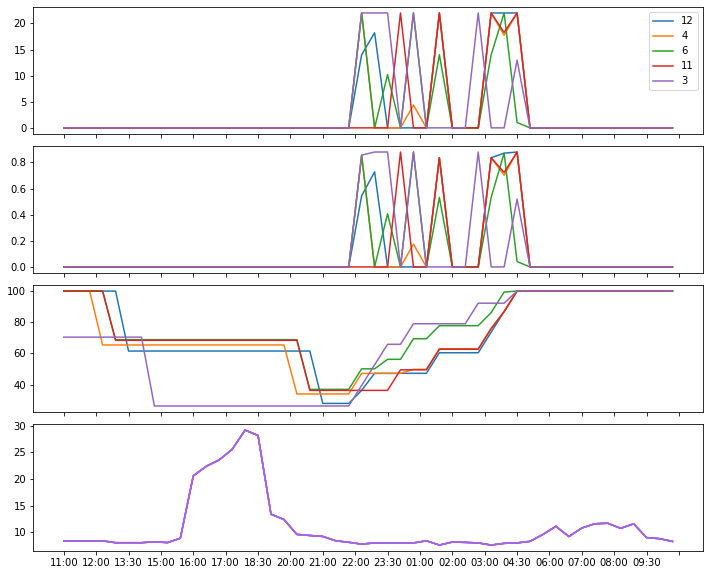

In [64]:
fig, axs = plt.subplots(
    4,
    figsize=(12,10),
    sharex=True, 
    gridspec_kw={'hspace':0.1})

x = range_profile.unstack().index.strftime('%H:%M')
cols = gv.CAT_COLS

axs[0].plot(
    x, 
    range_profile.unstack()[cols['OUTPUT'][ca]]*2)
axs[0].legend(list(vehicles))
axs[1].plot(
    x, 
    range_profile.unstack()[cols['ECOST'][ca]]/100)
axs[2].plot(
    x, 
    range_profile.unstack()[cols['SOC'][ca]])

axs[3].plot(x, 
range_profile.unstack()[cols['PRICE']['opt']], 
color=gv.FPS_PURPLE)
for ax in fig.get_axes():
    ax.xaxis.set_major_locator(plt.MaxNLocator(24))
fig.show()

In [65]:
list(vehicles)

[12, 4, 6, 11, 3]